## Magnetic Model Comparison

This notebook compares the CHAOS-6-Core models evaluated by two different implementations:

- [eoxmagmod](https://github.com/ESA-VirES/MagneticModel/tree/staging/eoxmagmod) (used by VirES)
- [chaosmagpy](http://www.spacecenter.dk/files/magnetic-models/CHAOS-6/) (reference Python implementation)


This version of the notebook corrects the error caused by the different decimal year/MJD2000 conversions:

- The `eoxmagmod` library converts the decimal year to MJD2000 so that a whole decimal year is always aligned with the midnight 1st of January.

- The `chaosmagpy` calculates the MJD2000 as $t_\text{MJD200} = 365.25 \times (t_\text{decimal year} - 2000)$

This version redefines the `eoxmagmod` model to use the same conversion as the `chaosmagpy` package.

In addition this version also evaluates values between the interpolation nodes.

In [1]:
from numpy import asarray

def decimal_year_to_mjd2000(decimal_year):
    return (asarray(decimal_year) - 2000) * 365.25

def mjd2000_to_decimal_year(mjd2000):
    return 2000.0 + asarray(mjd2000) / 365.25

### 1) load SHC model file

In [2]:
from os.path import basename
from eoxmagmod.data import CHAOS6_CORE_LATEST

print(basename(CHAOS6_CORE_LATEST))
print(open(CHAOS6_CORE_LATEST).read())

CHAOS-6-x7_core.shc
# CHAOS-6-x7 core field model                      
# Based on model iteration_1 of CF_CHAOS_09d_18.mat
# extracted on 09-Oct-2018 12:11:25                
  1  20 221   6   5
          1997.1020   1997.2019   1997.3018   1997.4018   1997.5017   1997.6016   1997.7016   1997.8015   1997.9014   1998.0014   1998.1013   1998.2012   1998.3012   1998.4011   1998.5010   1998.6010   1998.7009   1998.8008   1998.9008   1999.0007   1999.1006   1999.2005   1999.3005   1999.4004   1999.5003   1999.6003   1999.7008   1999.8012   1999.9017   2000.0022   2000.1027   2000.2026   2000.3025   2000.4025   2000.5024   2000.6023   2000.7023   2000.8022   2000.9021   2001.0021   2001.1020   2001.2019   2001.3018   2001.4018   2001.5017   2001.6016   2001.7016   2001.8015   2001.9014   2002.0014   2002.1013   2002.2012   2002.3012   2002.4011   2002.5010   2002.6010   2002.7009   2002.8008   2002.9008   2003.0007   2003.1006   2003.2005   2003.3005   2003.4004   2003.5003   2003.6003   20

/usr/local/conda/lib/python3.7/site-packages/spacepy/pycdf/__init__.py:1209: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class CDF(collections.MutableMapping):


### 2) generate times and locations

In [3]:
# generate random points
from math import pi
from numpy import sin, cos, dstack, linspace
from numpy.random import random, uniform

EARTH_RADIUS = 6371.2 # km
N_coords = 500

X = random((N_coords*2, 2))
X = X[X[..., 1] < sin(X[..., 0]*pi)][:N_coords, ...]
X[..., 0] = pi * (X[..., 0] - 0.5)
X[..., 1] = pi*(2.0*X[..., 1] / cos(X[..., 0]) - 1.0)
X *= 180./pi
lats = X[..., 0]
lons = X[..., 1]
rads = uniform(EARTH_RADIUS, 1.1*EARTH_RADIUS, N_coords)

coords = dstack((lats, lons, rads))[0]

In [4]:
#generate times
from eoxmagmod import load_model_shc
model_vires = load_model_shc(CHAOS6_CORE_LATEST)
N_times = 1000
start, end = model_vires.validity
times = linspace(start, end, num=N_times)
#times = decimal_year_to_mjd2000(model_vires.coefficients._times)
#N_times = len(times)

### 3) evaluate the VirES model

In [5]:
from numpy import empty
from eoxmagmod.magnetic_model.model import SphericalHarmomicGeomagneticModel
from eoxmagmod.magnetic_model.coefficients import (
    SparseSHCoefficientsConstant,
    SparseSHCoefficientsTimeDependent,
)
from eoxmagmod.magnetic_model.util import parse_file
from eoxmagmod.magnetic_model.parser_shc import parse_shc_file

def load_coeff_shc_mjd2000(path):
    """ Load coefficients from an SHC file (interpolated in the MJD2000 time domain) """
    data = parse_file(parse_shc_file, path)
    options = {
        key: decimal_year_to_mjd2000(data[key])
        for key in ("validity_start", "validity_end") if key in data
    }
    times = data["t"]
    if len(times) == 1:
        return SparseSHCoefficientsConstant(
            data["nm"], data["gh"][:, 0], **options
        )
    else:
        return SparseSHCoefficientsTimeDependent(
            data["nm"], data["gh"], decimal_year_to_mjd2000(times), **options
        )

model_vires = SphericalHarmomicGeomagneticModel(
    load_coeff_shc_mjd2000(CHAOS6_CORE_LATEST)
)

b_nec_vires = empty((N_times, N_coords, 3))

for idx, time in enumerate(times):
    b_nec_vires[idx, ...] = model_vires.eval(time, coords, scale=[1, 1, -1])

### 4) evaluate the reference model

In [6]:
from chaosmagpy import load_CHAOS_shcfile
model_ref = load_CHAOS_shcfile(CHAOS6_CORE_LATEST)

b_nec_ref = empty((N_times, N_coords, 3))

for idx, time in enumerate(times):
    a, b, c = model_ref(time, rads, 90.0 - lats, lons, source_list=['tdep'])
    b_nec_ref[idx, :, 0] = -b
    b_nec_ref[idx, :, 1] = c
    b_nec_ref[idx, :, 2] = -a

Computing time-dependent internal field up to degree 20.
Finished in 0.012853 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011985 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117297 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116065 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117623 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121067 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117705 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0180174 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116634 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118349 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118276 seconds.
Computing time-dependent internal 

Finished in 0.0135246 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120077 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117399 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011734 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117822 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118102 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118386 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117131 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.01182 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011784 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120548 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119466 seconds.
Compu

Finished in 0.0138072 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122215 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120577 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120479 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119286 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011707 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119978 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117603 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117196 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119599 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119013 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119013 seconds.
Co

Finished in 0.0118178 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0123629 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118081 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011803 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116387 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117711 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011728 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119159 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117706 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117319 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116364 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118566 seconds.
Com

Finished in 0.0136868 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121391 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121973 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119853 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012056 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120043 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120513 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118707 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011914 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119844 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119036 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121066 seconds.
Com

Finished in 0.0123726 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0135913 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012268 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121317 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011874 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119425 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120689 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011994 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120915 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120682 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120685 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118264 seconds.
Comp

Finished in 0.0124317 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012023 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119337 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119699 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117495 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119933 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011941 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117771 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118156 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119327 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118933 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118882 seconds.
Com

Finished in 0.0118968 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0135797 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0123164 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0126326 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122256 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119452 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119112 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117033 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120289 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122606 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119709 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0125503 seconds.
C

Finished in 0.0139864 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119524 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121048 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116258 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0124462 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0146406 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0126675 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122145 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117967 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121232 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0124433 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0124863 seconds.
C

Finished in 0.0141591 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119119 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117542 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120663 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0115201 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118258 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118203 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119324 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117849 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120542 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116623 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117351 seconds.
C

### 5) model comparison

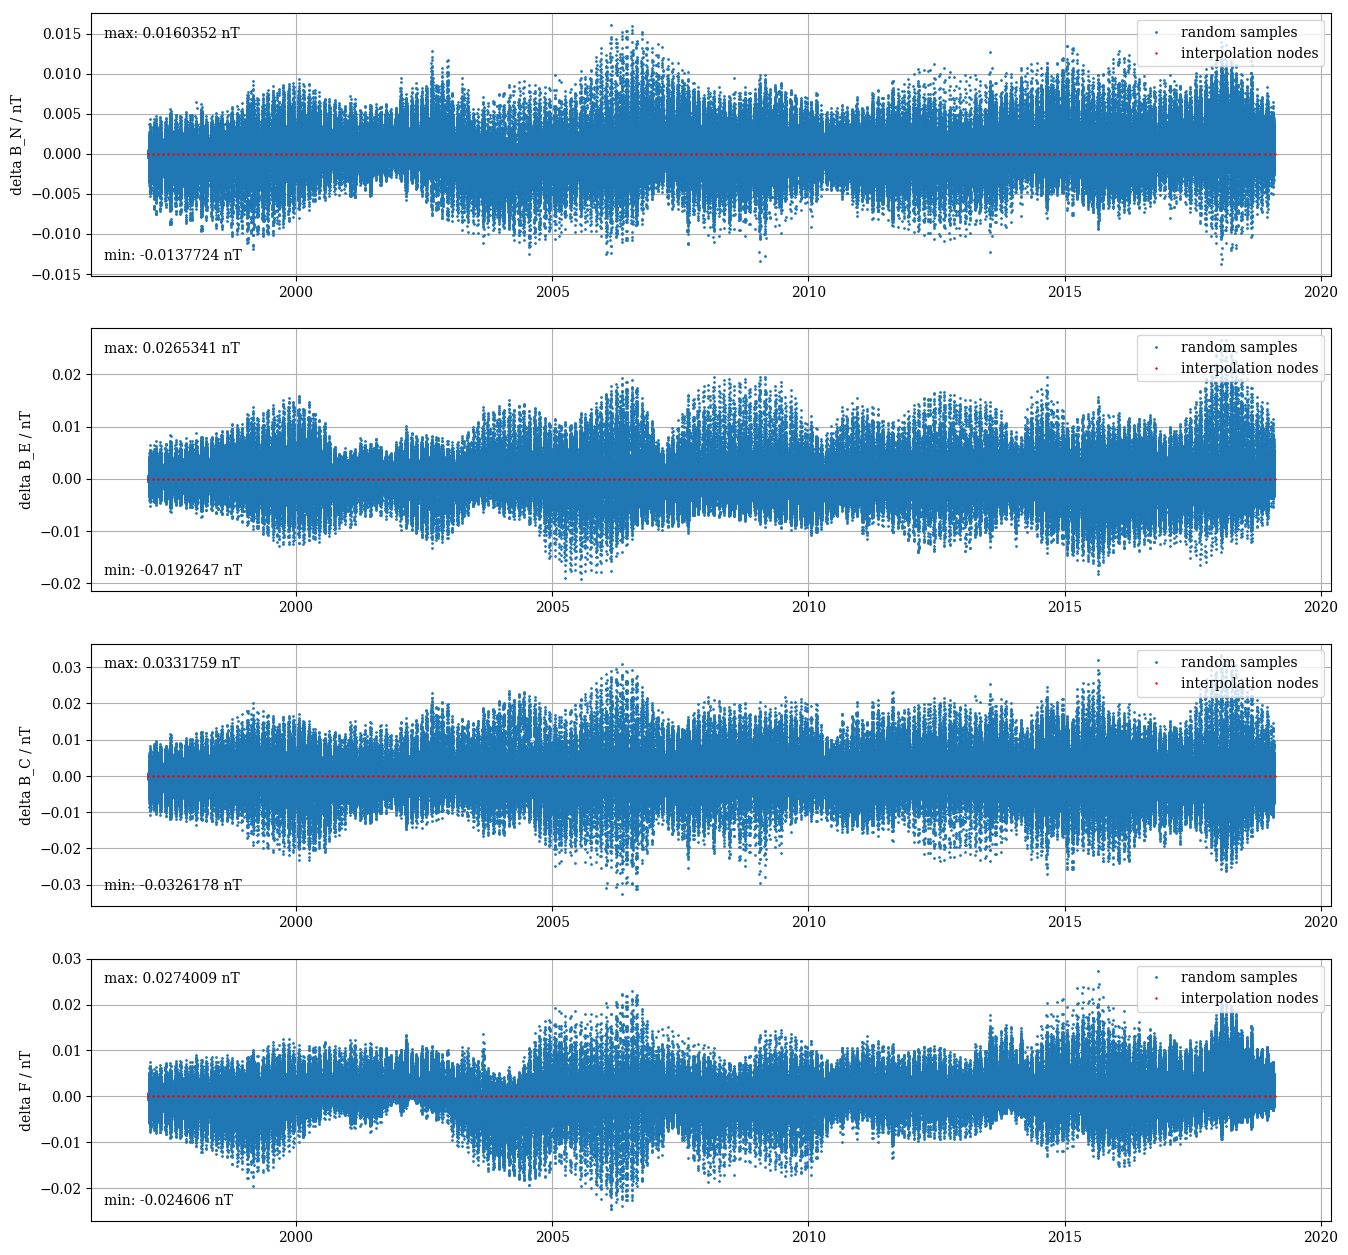

In [7]:
from numpy import zeros, concatenate, isnan
from matplotlib import pyplot as plt
from eoxmagmod import vnorm

node_times = mjd2000_to_decimal_year(model_vires.coefficients._times)
node_val = zeros(node_times.shape)

delta_b_nec = b_nec_vires - b_nec_ref
delta_f = vnorm(b_nec_vires) - vnorm(b_nec_ref)

fig = plt.figure(figsize=(16, 16), dpi=100)
plt.title("eoxmagmod vs chaosmagpy (CHAOS-6-Core, x7)")

times_dy = mjd2000_to_decimal_year(times)

def plot(ax, x0, y0, label):
    x, y = [], []
    for idx in range(0, N_coords):
        x.append(x0)
        y.append(y0[:, idx])
    x, y = concatenate(x), concatenate(y)
    plt.plot(x, y, '.', markersize=2, color='#1f77b4', label='random samples')
    plt.plot(node_times, node_val, '+r', markersize=2, label='interpolation nodes')
    plt.ylabel(label)
    plt.legend(loc='upper right')
    plt.text(
        0.01, 0.95, 'max: %g nT' % y[~isnan(y)].max(),
        horizontalalignment='left', verticalalignment='top', transform=ax.transAxes
    )
    plt.text(
        0.01, 0.05, 'min: %g nT' % y[~isnan(y)].min(),
        horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes
    )
    plt.grid()
    
ax = plt.subplot(4, 1, 1)
plot(ax, times_dy, delta_b_nec[..., 0], "delta B_N / nT")

ax = plt.subplot(4, 1, 2)
plot(ax, times_dy, delta_b_nec[..., 1], "delta B_E / nT")

ax = plt.subplot(4, 1, 3)
plot(ax, times_dy, delta_b_nec[..., 2], "delta B_C / nT")

ax = plt.subplot(4, 1, 4)
plot(ax, times_dy, delta_f, "delta F / nT")

plt.show()
%matplotlib inline

### 6) plot locations

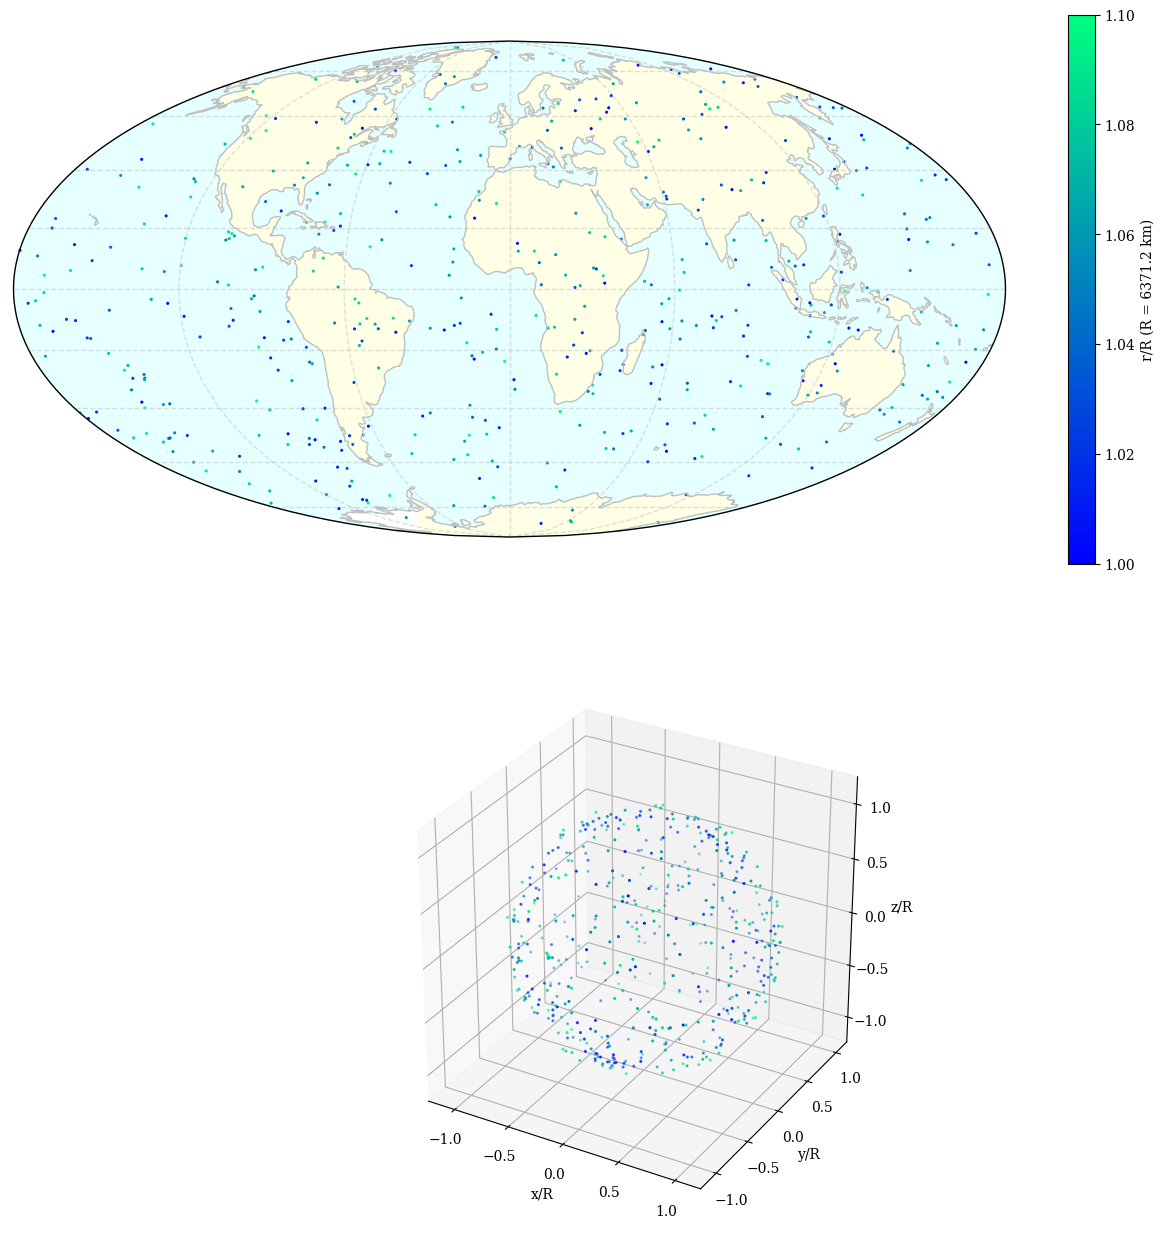

In [8]:
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, PlateCarree
from matplotlib import pyplot as plt
from matplotlib.cm import winter as colormap
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.mplot3d import Axes3D
from eoxmagmod import convert, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN
%matplotlib inline

norm = Normalize(vmin=1,vmax=1.1)

#help(ccrs)
fig = plt.figure(figsize=(16, 16), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1, projection=Mollweide())
gl = ax.gridlines(crs=PlateCarree(), draw_labels=False, linewidth=1, color='silver', alpha=0.5, linestyle='--')
ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
ax.add_feature(COASTLINE, edgecolor='silver')


obj = ax.scatter(
    lons, lats, c=rads/EARTH_RADIUS, s=1.5,
    cmap=colormap, norm=norm, transform=PlateCarree(),
     
)
cb = plt.colorbar(obj)
cb.ax.set_ylabel("r/R (R = %g km)" % EARTH_RADIUS)


ax = plt.subplot(2, 1, 2, projection='3d')

cart_coords = convert(coords, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN)/EARTH_RADIUS
obj = ax.scatter(
    cart_coords[:, 0], cart_coords[:, 1], cart_coords[:, 2], 
    c=rads/EARTH_RADIUS, s=1.5,
    cmap=colormap, norm=norm,
)

ax.set_aspect('equal','box')
ax.set_xlabel("x/R")
ax.set_ylabel("y/R")
ax.set_zlabel("z/R")

plt.show()